In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from support_functions import (atipicosAmissing, graficoVcramer, create_target_variable_boxplots)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from joblib import dump, load

seed = 42

Obtenemos la carpeta actual:

In [2]:
current_dir = Path.cwd()
DATASETS_LOCATION = os.path.join(current_dir.parent.parent.parent, 'datasets')
MODELS_LOCATION = os.path.join(current_dir.parent.parent, 'models')

Cargamos el dataset en un dataframe, y definimos nuestra variable target:

In [3]:
df_disease = pd.read_csv(os.path.join(DATASETS_LOCATION, 'blood_samples_dataset.csv'))
var_target = "Disease"

# Análisis exploratorio de los datos

Empecemos comprobando el formato de cada una de nuestras variables:

In [4]:
df_disease.dtypes

Glucose                                      float64
Cholesterol                                  float64
Hemoglobin                                   float64
Platelets                                    float64
White Blood Cells                            float64
Red Blood Cells                              float64
Hematocrit                                   float64
Mean Corpuscular Volume                      float64
Mean Corpuscular Hemoglobin                  float64
Mean Corpuscular Hemoglobin Concentration    float64
Insulin                                      float64
BMI                                          float64
Systolic Blood Pressure                      float64
Diastolic Blood Pressure                     float64
Triglycerides                                float64
HbA1c                                        float64
LDL Cholesterol                              float64
HDL Cholesterol                              float64
ALT                                          f

Observamos que todas tienen el tipo de datos que queremos. Veamos ahora si hay valores perdidos.

## Valores perdidos

Comprobemos si hay valores perdidos en las variables:

In [5]:
print(f"Hay {df_disease.isna().sum().sum()} valores perdidos")

Hay 0 valores perdidos


## Valores erróneos

Veamos ahora si hay valores erróneos:

In [6]:
descriptivos_max_min = round(df_disease.describe().T[['max', 'min']],2)
descriptivos_max_min

,max,min
Glucose,0.99,0.00
Cholesterol,1.00,0.00
Hemoglobin,1.00,0.00
Platelets,1.00,0.00
White Blood Cells,1.00,-0.00
Red Blood Cells,1.00,0.00
Hematocrit,1.00,0.00
Mean Corpuscular Volume,1.00,0.00
Mean Corpuscular Hemoglobin,1.00,-0.00
Mean Corpuscular Hemoglobin Concentration,1.00,0.00


Observamos que todos los valores están correctamente entre 0 y 1. Pasemos ahora a ver si hay datos atípicos.


## Datos atípicos

Se tiene que la proporción de valores atípicos se calcula dividiendo la cantidad de valroes atípicos por el número total de filas:

In [7]:
numericas_input = df_disease.select_dtypes(include = ['int', 'int32', 'int64','float', 'float32', 'float64']).columns
resultados = {x: atipicosAmissing(df_disease[x])[1] / len(df_disease) for x in numericas_input}
resultados = {key: value for key, value in resultados.items() if value!= 0} # Elimino la variable si no tiene valores atípicos
if resultados:
    for key, value in resultados.items():
        print(f'{key}: {round(value*100,2)}% de valores atípicos en la variable')
else:
    print("No hay datos atípicos")

No hay datos atípicos


Veamos cómo está distribuida nuestra variable target.

## Distibución de la variable target

In [8]:
df_disease[var_target].value_counts()

Disease
Diabetes    834
Anemia      707
Healthy     561
Thalasse    557
Thromboc    139
Heart Di     39
Name: count, dtype: int64

Procedemos a renombrar algunas de las clases de la variable target, para su mejor comprensión. Además, también vamos a quitar una de las clases, "heart di", ya que no la vamos a utilizar:

In [9]:
df_disease[var_target] = df_disease[var_target].replace({
    'Thalasse': 'Thalassemia',
    'Thromboc': 'Thrombosis'
})

df_disease = df_disease[df_disease[var_target] != 'Heart Di']

# Veamos que nuestros cambios se han realizado correctamente
print(df_disease[var_target].value_counts())

Disease
Diabetes       834
Anemia         707
Healthy        561
Thalassemia    557
Thrombosis     139
Name: count, dtype: int64


Observamos que ya está todo tal y como queremos. Pasemos a ver la correlación entre variables.

## Correlación entre variables

Empecemos viendo el gráfico de V de Cramer:

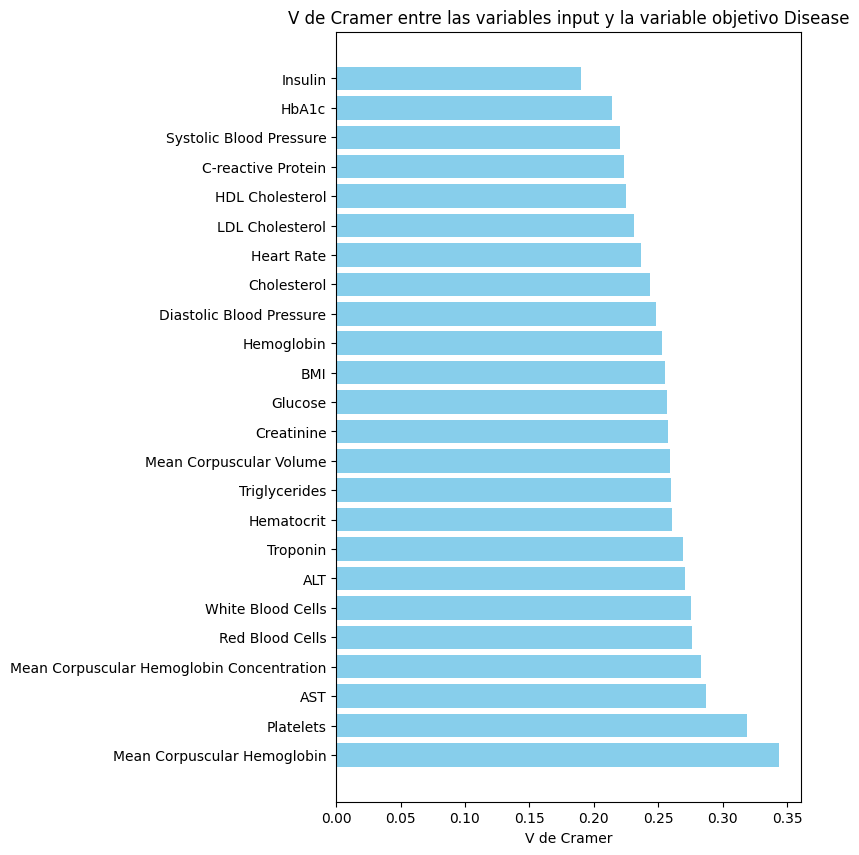

{'Mean Corpuscular Hemoglobin': 0.3435722528967313,
 'Platelets': 0.3187702624531197,
 'AST': 0.28735863127411865,
 'Mean Corpuscular Hemoglobin Concentration': 0.28292157988652966,
 'Red Blood Cells': 0.2757430972696437,
 'White Blood Cells': 0.2755488463251754,
 'ALT': 0.27029673838408164,
 'Troponin': 0.26946401696525846,
 'Hematocrit': 0.2605545295361615,
 'Triglycerides': 0.25961671658786817,
 'Mean Corpuscular Volume': 0.25874336395395536,
 'Creatinine': 0.25784426592757037,
 'Glucose': 0.25640352378625964,
 'BMI': 0.25547676678459463,
 'Hemoglobin': 0.25316357228348,
 'Diastolic Blood Pressure': 0.24836291488530532,
 'Cholesterol': 0.24338911973816213,
 'Heart Rate': 0.23671738116169708,
 'LDL Cholesterol': 0.23103428924150282,
 'HDL Cholesterol': 0.22517992182149074,
 'C-reactive Protein': 0.2230886805522568,
 'Systolic Blood Pressure': 0.2202299294519316,
 'HbA1c': 0.21397251873059836,
 'Insulin': 0.19011220727152253}

In [10]:
graficoVcramer(df_disease.drop(columns=[var_target]), df_disease[var_target])

Tal y como se puede observar, las variables "Mean Corpuscular Hemoglobin" y "Platelets" muestran los valores de V de Cramer más altos. Esto indica una relación más fuerte con la variable objetivo "Disease". Sin embargo, aunque estos valores sean más altos, siguen siendo muy similares a los valores de V de Cramer del resto de variables. Por tanto, no descartaremos ninguna variable a la hora de realizar nuestro modelo.

Ahora, visualicemos la relacion entre las diversas variables de nuestro conjunto de datos y nuestra variable objetivo "Disease":

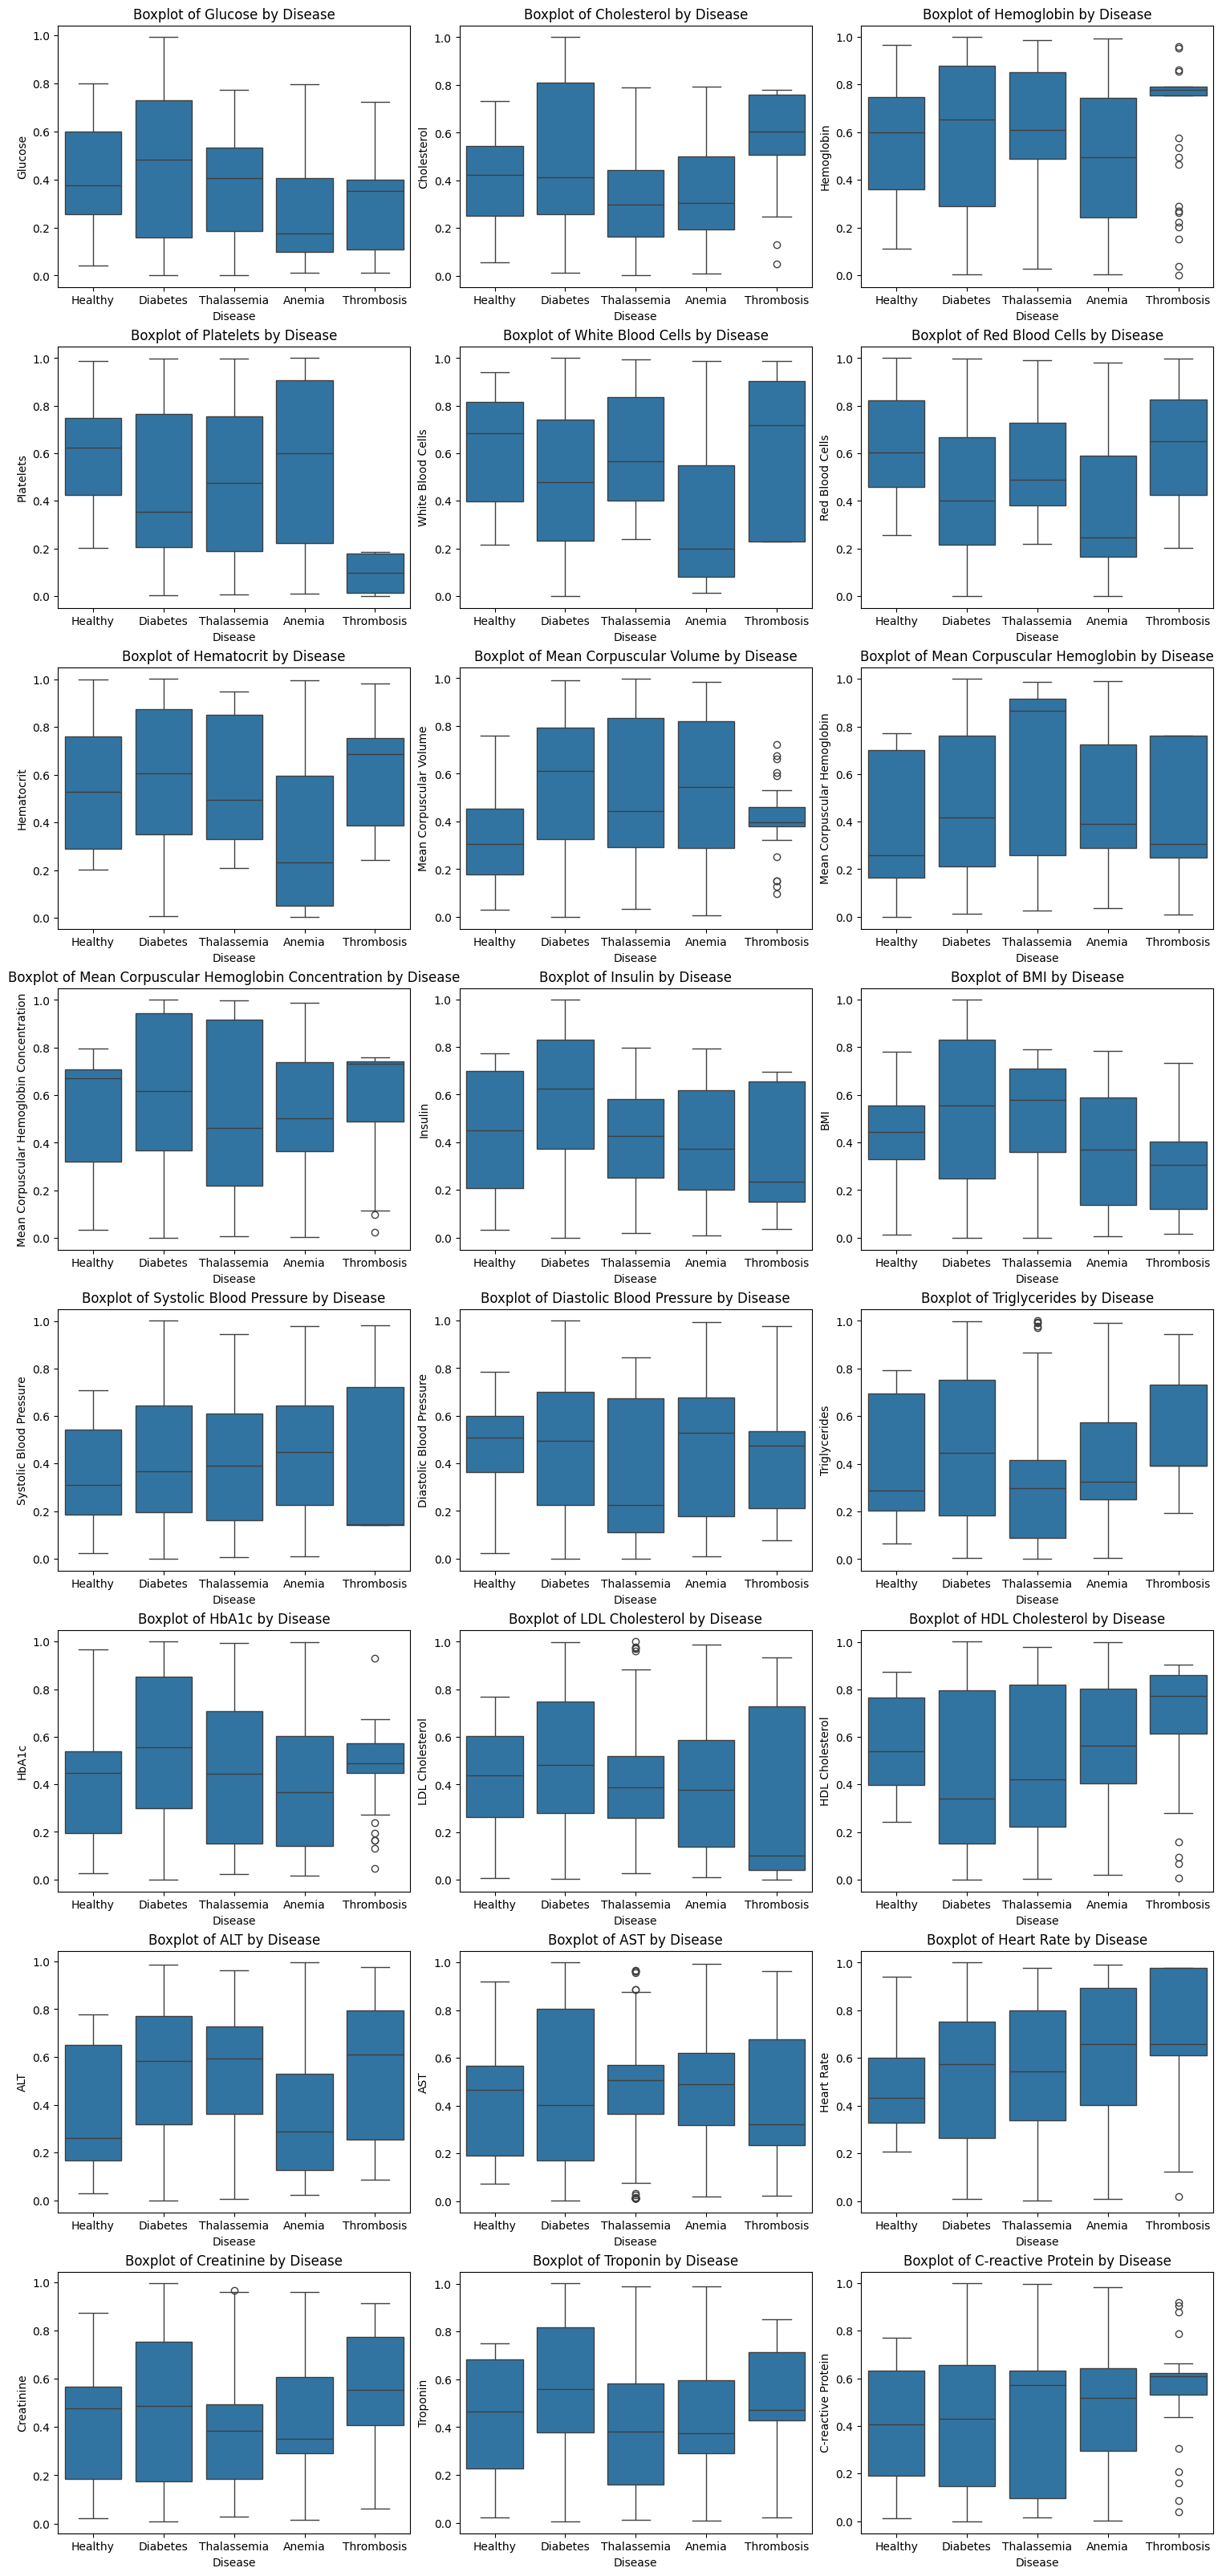

In [11]:
create_target_variable_boxplots(dataframe=df_disease,
                                target_col=var_target)

De estos gráficos, podemos observar lo siguiente:
- Los niveles de hemoglobina son más bajos en "Thalassemia" y "Anemia", mientras que son considerablemente más altos para "Thrombosis". Por tanto, esta variable es un buen indicador para identificar enfermedades como "Thalassemia", "Anemia" o "Thrombosis" debido a sus diferencias extremas en los valores.
- Los niveles de plaquetas ("Platelets") son significativamente más bajos en "Thrombosis" en comparación con el resto, con una mediana visiblemente inferior y una menor dispersión concentrada en valores bajos. Esto convierte a las plaquetas en un fuerte indicador para "Thrombosis".
- Los valores de "C-reactive Protein" son más altos en "Thrombosis", con una mediana claramente superior y una dispersión concentrada en torno a valores elevados. Esto sugiere que esta variable es un fuerte indicador para "Thrombosis".
- "HbA1c" y "Glucose" presentan valores significativamente más altos para "Diabetes", como era de esperarse dada su relación directa con esta enfermedad. Por tanto, son buenos predictores para identificar "Diabetes".
- Por otro lado, observamos que "Thalassemia" tiene valores significativamente más bajos de "Mean Corpuscular Volume", con una distribución muy concentrada en torno a la mediana, mientras que las otras categorías muestran distribuciones más amplias. Esto hace del volumen corpuscular medio un buen predictor para "Thalassemia".
- El índice de masa corporal (BMI) es más alto en "Diabetes" y más bajo en "Thalassemia". Por tanto, puede ser un buen predictor indirecto para estas dos enfermedades.
- Los niveles de colesterol HDL son más bajos en "Thalassemia" y más altos en "Healthy". Luego, puede ser útil para diferenciar "Thalassemia" y personas saludables.

## Correlación entre todas las variables numéricas

Veamos ahora la correlación entre todas las variables numéricas:

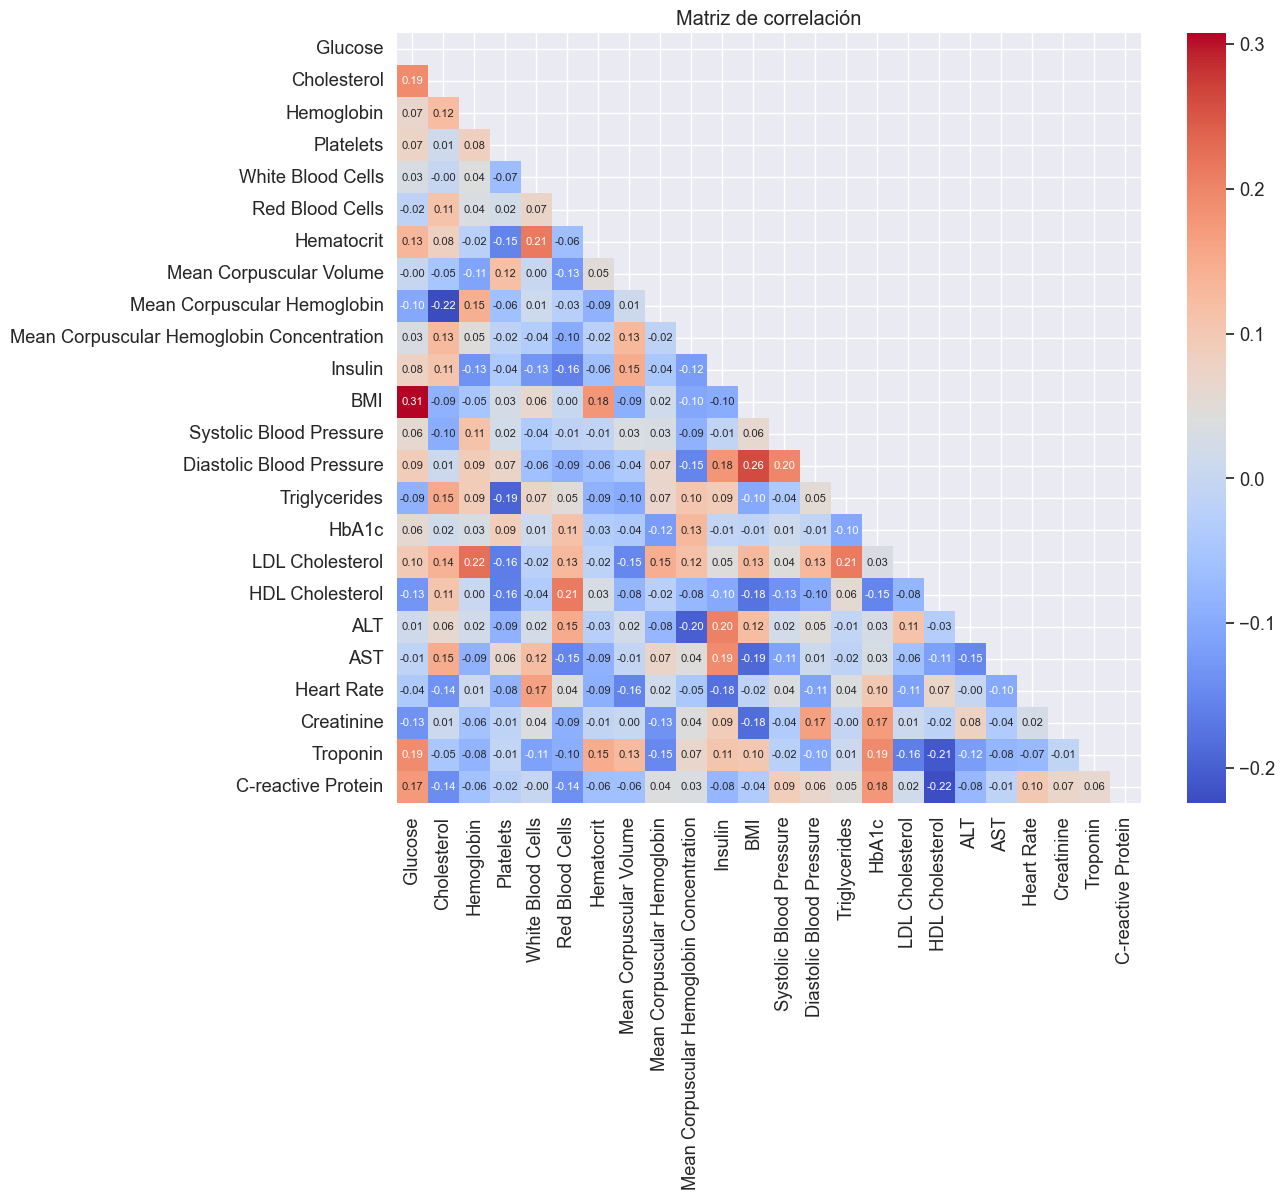

In [12]:
# Obtener las columnas numéricas del DataFrame 'datos_input'
numericas = df_disease.select_dtypes(include=['int', 'float']).columns
# Calcular la matriz de correlación de Pearson entre la variable objetivo continua ('varObjCont') y las variables numéricas
matriz_corr = df_disease[numericas].corr(method = 'pearson')
# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask, annot_kws={"size": 8})
plt.title("Matriz de correlación")
plt.show()

Tal y como se puede ver, no hay una una correlación evidente entre las diferentes variables numéricas del dataset.

Como ya hemos terminado el análisis exploratorio de los datos, pasemos a realizar el train test split.

# Train test split

Procederemos a dividir nuestro conjunto de datos en conjunto de entrenamiento y conjunto de pruebas. Además, realizaremos el one-hot encoding para la variable target, puesto que es categórica:

In [13]:
X = df_disease.drop(columns=[var_target])  
y = df_disease[var_target]  # La variable objetivo

# Realizamos el train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# One-Hot Encoding para la variable target
encoder = OneHotEncoder(sparse_output=False)  
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

print(f"Categorías codificadas: {encoder.categories_} \n")
print(f"Tamaño del dataset de entrenamiento: {len(X_train)}")
print(f"Tamaño del dataset de prueba: {len(X_test)}")


Categorías codificadas: [array(['Anemia', 'Diabetes', 'Healthy', 'Thalassemia', 'Thrombosis'],
      dtype=object)] 

Tamaño del dataset de entrenamiento: 2238
Tamaño del dataset de prueba: 560


En este caso, dado que los valores de los datos oscilan entre 0 y 1 (y sólo en un caso 0.99), no tiene sentido normalizar los datos, ya que ya están en un rango adecuado para ser utilizados directamente en los modelos predictivos.

# Creación del modelo predictivo

Ahora, pasemos a construir nuestro modelo predictivo utilizando diferentes técnicas de machine learning para evaluar cuál nos ofrece los mejores resultados. Las técnicas que vamos a probar son SVM, KNN Neighbours, Decission Tree y XGBoost. 

## SVM

### Entrenamiento del modelo

In [14]:
# Definición de los parámetros para el GridSearch
svm_params = {
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
}

# Pipeline para el modelo SVM
svm_pipeline = Pipeline([
    ('svm', SVC(probability=True, random_state=seed, class_weight='balanced'))
])

# Grid Search para optimizar los parámetros
svm_grid_search = GridSearchCV(
    svm_pipeline, svm_params, cv=3, scoring='accuracy', n_jobs=-1
)

print("Inicio la búsqueda de los mejores parámetros para SVM...")
svm_grid_search.fit(X_train, y_train)

# Mejor modelo sin Bagging
best_svm = svm_grid_search.best_estimator_
print(f"Mejores parámetros SVM sin Bagging: {svm_grid_search.best_params_}")

Inicio la búsqueda de los mejores parámetros para SVM...
Mejores parámetros SVM sin Bagging: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


### Evaluación

Evaluemos el modelo optimizado sin Bagging:

In [15]:
y_pred_best_svm_train = best_svm.predict(X_train)
print("\nInforme de clasificación para SVM optimizado:")
print(classification_report(y_train, y_pred_best_svm_train))


Informe de clasificación para SVM optimizado:
              precision    recall  f1-score   support

      Anemia       1.00      1.00      1.00       557
    Diabetes       1.00      1.00      1.00       663
     Healthy       1.00      1.00      1.00       445
 Thalassemia       1.00      1.00      1.00       462
  Thrombosis       1.00      1.00      1.00       111

    accuracy                           1.00      2238
   macro avg       1.00      1.00      1.00      2238
weighted avg       1.00      1.00      1.00      2238



In [16]:
y_pred_best_svm_test = best_svm.predict(X_test)
print("\nInforme de clasificación para SVM optimizado:")
print(classification_report(y_test, y_pred_best_svm_test))


Informe de clasificación para SVM optimizado:
              precision    recall  f1-score   support

      Anemia       0.97      0.97      0.97       150
    Diabetes       0.93      0.98      0.95       171
     Healthy       0.99      0.98      0.99       116
 Thalassemia       0.99      0.96      0.97        95
  Thrombosis       1.00      0.89      0.94        28

    accuracy                           0.97       560
   macro avg       0.98      0.96      0.97       560
weighted avg       0.97      0.97      0.97       560



Y visualicemos su matriz de confusión:

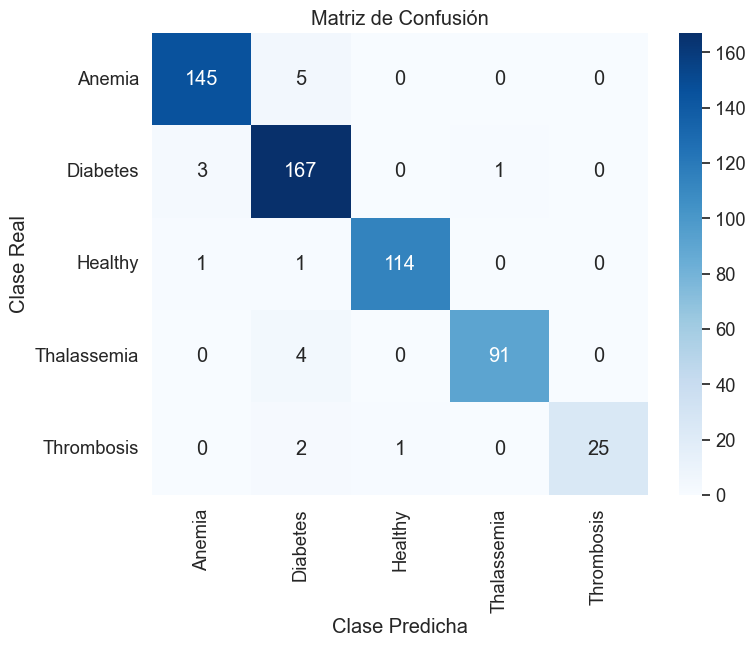

In [17]:
cm = confusion_matrix(y_test, y_pred_best_svm_test)
class_names = encoder.categories_[0]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()

Ahora, evaluemos utilizando la validación cruzada:

In [51]:
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.95442359 0.95040214 0.95308311]
Accuracy media de la validación cruzada: 0.953
Desviación estándar de las diferentes accuracys de la CV: 0.002


Observamos que la accuracy en train es de 1, y en test 0.97. Aunque hay un ligero overfitting, el modelo sigue generalizando bastante bien en el conjunto de prueba, ya que se obtiene una accuracy del 97%. Por otro lado, la validación cruzada muestra una accuracy media de 0.95, lo que indica que el modelo tiene un rendimiento consistente en diferentes particiones de los datos de entrenamiento. Por tanto, nuestro modelo también es muy robusto.

### Conclusiones

El resultado es muy bueno. El kernel no lineal de la SVM, combinado con la opción class_weight='balanced', permite obtener un rendimiento excelente a pesar de que el conjunto de datos es pequeño y las clases están desbalanceadas.

## KNN Neighbours

### Preprocesamiento

Tal y como hemos visto anteriormente, los datos no tienen valores atípicos o faltantes. Además, ya están normalizados. Por tanto, podemos pasar a entrenar el modelo.

### Modelo base KNN

Construyamos nuestro modelo base con KNN:

In [18]:
KNN=KNeighborsClassifier()

KNN.fit(X_train, y_train) 
print('La accuracy del modelo en train es %.3f,' %KNN.score(X_train, y_train), 
      'y en test es %.3f ' %KNN.score(X_test, y_test))

La accuracy del modelo en train es 0.927, y en test es 0.918 


Observamos que obtenemos un buen resultado. Apliquemos ahora Bagging.

#### Bagging

##### Entrenamiento del modelo

Entrenemos nuestro modelo de Bagging con KNN para diferentes combinaciones de hiperparámetros:

In [19]:
n_estimators_list = [50, 100, 200]
max_samples_list = [0.3, 0.5, 0.7]
max_features_list = [0.2, 0.3, 0.4]
n_neighbors_list = [2, 3, 4]

results_knn = []

for n_estimators in n_estimators_list:
    print(f"processing {n_estimators} estimators")
    for max_samples in max_samples_list:
        print(f"processing {max_samples} max_samples")
        for max_features in max_features_list:
            for n_neighbors in n_neighbors_list:
                # Crea el clasificador Bagging con KNN
                bagging_model = BaggingClassifier(
                    KNeighborsClassifier(n_neighbors=n_neighbors),
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    max_features=max_features,
                    bootstrap_features=True,
                    random_state=seed
                )
                
                # Adiestra el clasificador Bagging
                bagging_model.fit(X_train, y_train)
                
                train_score = bagging_model.score(X_train, y_train)
                test_score = bagging_model.score(X_test, y_test)
                
                results_knn.append({
                    'n_estimators': int(n_estimators),
                    'max_samples': max_samples,
                    'max_features': max_features,
                    'n_neighbors': n_neighbors,
                    'train_score': train_score,
                    'test_score': test_score
                })

# Crea un DataFrame con los resultados
results_knn_df = pd.DataFrame(results_knn)

processing 50 estimators
processing 0.3 max_samples
processing 0.5 max_samples
processing 0.7 max_samples
processing 100 estimators
processing 0.3 max_samples
processing 0.5 max_samples
processing 0.7 max_samples
processing 200 estimators
processing 0.3 max_samples
processing 0.5 max_samples
processing 0.7 max_samples


##### Evaluación

Evaluemos ahora nuestro modelo:

In [20]:
results_knn_df = results_knn_df.sort_values('test_score', ascending=False).head()
results_knn_df.head(3)

,n_estimators,max_samples,max_features,n_neighbors,train_score,test_score
40,100,0.5,0.3,3,0.976765,0.957143
49,100,0.7,0.3,3,0.983467,0.957143
66,200,0.5,0.3,2,0.989723,0.957143


In [21]:
best_params_bag_knn = dict(results_knn_df.iloc[0][['n_estimators','max_samples','max_features']])
best_params_bag_knn['n_estimators'] = int(best_params_bag_knn['n_estimators'])
best_knn_neighb = int(results_knn_df.iloc[0][['n_neighbors']])
best_params_bag_knn, best_knn_neighb

C:\Users\maria\AppData\Local\Temp\ipykernel_9420\205366803.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_knn_neighb = int(results_knn_df.iloc[0][['n_neighbors']])


({'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.3}, 3)

Realicemos la validación cruzada y obtengamos los resultados:

In [22]:
best_model_bagging_knn = BaggingClassifier(
                                            KNeighborsClassifier(n_neighbors=best_knn_neighb),
                                            **best_params_bag_knn,
                                            bootstrap_features=True,
                                            random_state=seed
                                        )

cv_scores = cross_val_score(best_model_bagging_knn, X_train, y_train, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.94906166 0.94772118 0.94235925]
Accuracy media de la validación cruzada: 0.946
Desviación estándar de las diferentes accuracys de la CV: 0.003


Calculemos la accuracy en train y en test para el mejor modelo obtenido:

In [23]:
best_model_bagging_knn.fit(X_train, y_train)
best_y_pred_gab_knn_test = best_model_bagging_knn.predict(X_test)
best_y_pred_gab_knn_train = best_model_bagging_knn.predict(X_train)

print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,best_y_pred_gab_knn_train)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,best_y_pred_gab_knn_test)}')

Se tiene un accuracy para train de: 0.9767649687220733
Se tiene un accuracy para test de: 0.9571428571428572


Observamos que la accuracy en train es de 0.97, y en test 0.95. El modelo generaliza bastante bien en el conjunto de prueba, ya que se obtiene una accuracy del 95%. Por otro lado, la validación cruzada muestra una accuracy media de 0.94, lo que indica que el modelo tiene un rendimiento consistente en diferentes particiones de los datos de entrenamiento. Por tanto, nuestro modelo también es muy robusto.

### Conclusiones

El modelo KNN tiene un rendimiento muy bueno, considerando el bajo número de vecinos (*K-neighbours*) seleccionados. Entre las razones principales, esto se debe a la ausencia de valores atípicos en el conjunto de datos, lo que facilita una agrupación (*clusterización*) más efectiva.

## Decission Tree

### Entrenamiento del modelo

#### Modelo base

Empecemos construyendo el primer modelo de árbol de decisión, con todas las variables y con profundidad máxima 5:

In [25]:
arbol1 = DecisionTreeClassifier(min_samples_split=30, criterion='gini', max_depth = 5)
arbol1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=30)

Calculamos las predicciones en train y en test, y visualizamos la matriz de confusión:

In [26]:
y_train_pred = arbol1.predict(X_train)
y_test_pred = arbol1.predict(X_test)
print("\nInforme de clasificación train:")
print(classification_report(y_train, y_train_pred))
print("\nInforme de clasificación test:")
print(classification_report(y_test, y_test_pred))


Informe de clasificación train:
              precision    recall  f1-score   support

      Anemia       0.98      0.81      0.88       557
    Diabetes       0.89      0.59      0.71       664
     Healthy       0.56      1.00      0.72       444
 Thalassemia       0.94      0.70      0.80       462
  Thrombosis       0.54      0.98      0.70       111

    accuracy                           0.77      2238
   macro avg       0.78      0.82      0.76      2238
weighted avg       0.84      0.77      0.77      2238


Informe de clasificación test:
              precision    recall  f1-score   support

      Anemia       0.98      0.81      0.89       150
    Diabetes       0.89      0.56      0.69       170
     Healthy       0.58      1.00      0.74       117
 Thalassemia       0.95      0.80      0.87        95
  Thrombosis       0.58      1.00      0.74        28

    accuracy                           0.78       560
   macro avg       0.80      0.83      0.78       560
weighted avg

Observamos que tiene una accuracy en train de 0.77, y una accuracy en test de 0.78.

### Fine tuning

Realizamos ahora el tuneo y la evaluación predictiva del modelo, utilizando la validación cruzada y el GridSearchCV:

In [27]:
#cpp_alpha es el parámetro de complejidad, el cual establece “penalizaciones” si se producen muchas divisiones. Cuanto más alto
# más pequeño será el árbol. Lo insertamos entre los parámetros para evitar overfitting
params = {
    'max_depth': [5, 10, 20, 25],
    'min_samples_split': [10, 30, 50],
    'criterion': ["gini", "entropy"],  
    'ccp_alpha': [0.0001, 0.001, 0.005, 0.015]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']  

# cv = crossvalidation
grid_search = GridSearchCV(estimator=arbol1, 
                           param_grid=params, 
                           cv=3, scoring = scoring_metrics, refit='accuracy')
grid_search.fit(X_train, y_train)

c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=5,
                                              min_samples_split=30),
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.005, 0.015],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 25],
                         'min_samples_split': [10, 30, 50]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

### Evaluación

Evaluemos nuestro modelo en el conjunto de prueba:

In [28]:
results = pd.DataFrame(grid_search.cv_results_)
accuracy_best_params = results.sort_values('rank_test_accuracy').iloc[0].params
accuracy_best_params

{'ccp_alpha': 0.001,
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 30}

In [29]:
best_model_tree = DecisionTreeClassifier(**accuracy_best_params)
best_model_tree.fit(X_train, y_train)
y_train_pred = best_model_tree.predict(X_train)
y_test_pred = best_model_tree.predict(X_test)

print("\nInforme de clasificación train:")
print(classification_report(y_train, y_train_pred))
print("\nInforme de clasificación test:")
print(classification_report(y_test, y_test_pred))


Informe de clasificación train:
              precision    recall  f1-score   support

      Anemia       0.98      0.99      0.98       557
    Diabetes       0.99      0.99      0.99       664
     Healthy       1.00      1.00      1.00       444
 Thalassemia       1.00      0.99      0.99       462
  Thrombosis       1.00      0.97      0.99       111

    accuracy                           0.99      2238
   macro avg       0.99      0.99      0.99      2238
weighted avg       0.99      0.99      0.99      2238


Informe de clasificación test:
              precision    recall  f1-score   support

      Anemia       0.96      0.95      0.95       150
    Diabetes       0.95      0.94      0.94       170
     Healthy       0.99      1.00      1.00       117
 Thalassemia       0.97      0.99      0.98        95
  Thrombosis       0.90      0.93      0.91        28

    accuracy                           0.96       560
   macro avg       0.95      0.96      0.96       560
weighted avg

In [30]:
cv_scores = cross_val_score(best_model_tree, X_train, y_train_encoded, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.95576408 0.95576408 0.91957105]
Accuracy media de la validación cruzada: 0.944
Desviación estándar de las diferentes accuracys de la CV: 0.017


Observamos que la accuracy en train es de 0.99, y en test 0.96. El modelo generaliza bastante bien en el conjunto de prueba, ya que se obtiene una accuracy del 96%. Por otro lado, la validación cruzada muestra una accuracy media de 0.94, lo que indica que el modelo tiene un rendimiento consistente en diferentes particiones de los datos de entrenamiento. Por tanto, nuestro modelo también es muy robusto.

### Análisis gráfico de los resultados

Para esto utilizaremos el modelo base, ya que tiene una menor profundidad y permite, aun así, extraer el comportamiento general de las variables.

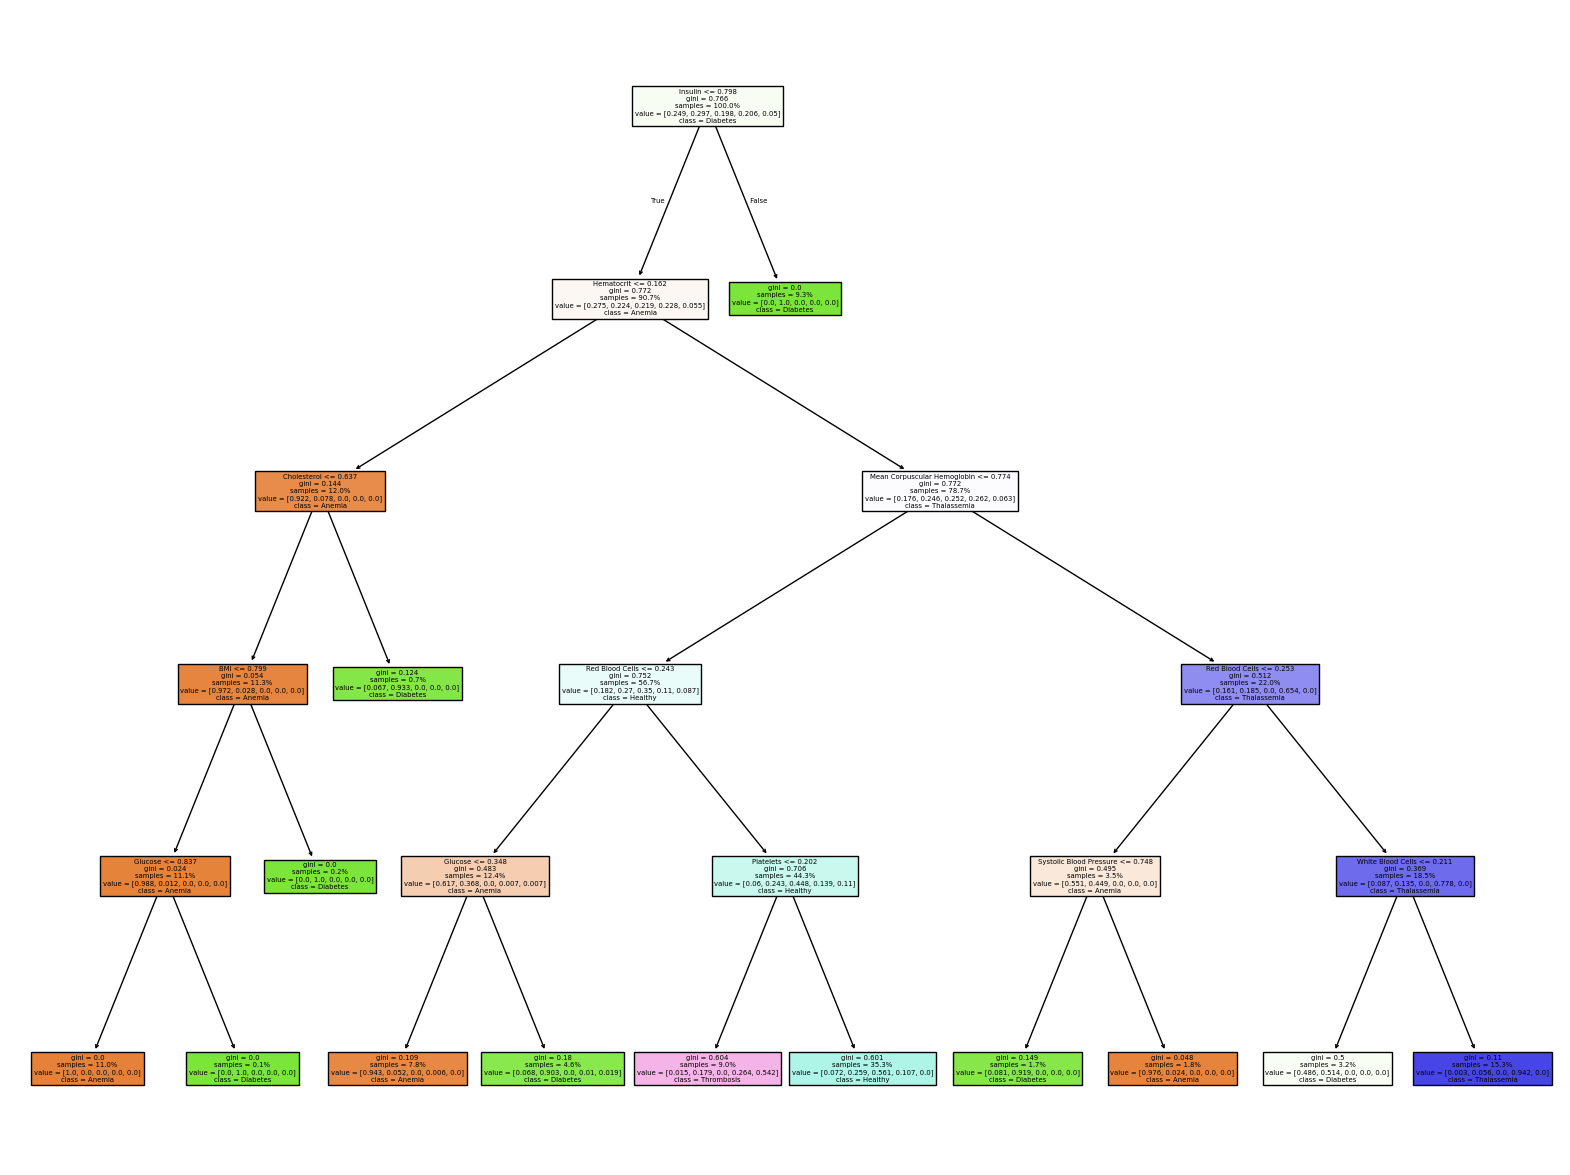

In [ ]:
arbol1.fit(X_train, y_train)
plt.figure(figsize=(20, 15))
plot_tree(arbol1, feature_names=X_train.columns.tolist(), filled=True,
         proportion = True, class_names=arbol1.classes_.tolist())
plt.show()

Observando el árbol de decisión se pueden extraer las siguientes conclusiones específicas:
- Variable principal (nodo raíz): La primera división se realiza en función de la variable "Insulin", lo que indica que es la característica más importante para la clasificación en este conjunto de datos.
- Decisiones posteriores:
    - Si "Insulin" es menor o igual a un cierto umbral, el modelo considera "Hematocrit" como la siguiente variable más relevante para segmentar los datos.
    - Si "Insulin" supera el umbral, entonces se obtendrá ya una de las predicciones (en este caso, diabetes).
    - Siguiendo con la siguiente variable más relevante, "Hematocrit", si esta es menor o igual que un cierto umbral, el modelo considerará "Cholesterol" como la siguiente variable más relevante.
    - Si "Cholesterol" supera el umbral, "Mean Corpuscular Hemoglobin" será la siguiente variable más relevante.
- Hojas finales: Cada hoja contiene un grupo de predicciones clasificadas (valores de salida), junto con una distribución de las observaciones en cada clase. Esto sugiere que el modelo hace una clasificación precisa basada en los valores umbral de las variables clave. Aunque las divisiones parecen bien distribuidas, algunas ramas más profundas podrían ser indicativas de casos más específicos o complejos en los datos.

### Conclusiones

Nuestro modelo Decission Tree ha demostrado ser muy efectivo para el conjunto de datos, con un alto rendimiento, una baja variabilidad entre los pliegues de validación cruzada, y una buena capacidad de generalización a nuevos datos.

## XGBoost

Construyamos ahora nuestro modelo de XGBoost:

In [32]:
xgb_classifier = XGBClassifier(booster = 'gbtree', n_estimators = 200, 
                               eta = 0.1, gamma = 1, random_state=seed, max_depth = 15, tree_method = 'hist')
xgb_classifier.fit(X_train, y_train_encoded)
y_pred_base = xgb_classifier.predict(X_test)

Veamos cual es la accuracy en train y en test:

In [33]:
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_encoded,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_encoded,y_test_pred)}')

Se tiene un accuracy para train de: 0.9995531724754245
Se tiene un accuracy para test de: 0.9678571428571429


Por lo tanto, nuestro modelo tiene una buena accuracy y no presenta overfitting.

### Fine tunning

Hagamos el Grid Search y veamos qué resultados obtenemos:

In [48]:
params = {
    'n_estimators': [50,100,200],
    'eta' : [0.1,0.4,0.7],
    'gamma' : [0.1,0.5,1],
    'max_depth': [10, 15]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

grid_search_XGB = GridSearchCV(estimator=xgb_classifier, 
                           param_grid=params, 
                           cv=3, scoring = scoring_metrics, refit='accuracy')
grid_search_XGB.fit(X_train, y_train_encoded)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric=None, feature_types=None,
                                     gamma=1, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_r...
                                     max_delta_step=None, max_depth=15,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'eta': [0.1, 0.4, 0.7], 'gamma': [0.1, 0.5, 1],
                         'max_depth': [10, 15],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

### Evaluación

Procedamos a evaluar nuestro modelo:

In [49]:
results = pd.DataFrame(grid_search_XGB.cv_results_)
accuracy_best_params = results.sort_values('rank_test_accuracy').iloc[0].params
accuracy_best_params

{'eta': 0.1, 'gamma': 0.5, 'max_depth': 15, 'n_estimators': 100}

In [50]:
modelo_XGB = grid_search_XGB.best_estimator_

y_train_pred_xgb = modelo_XGB.predict(X_train)
y_test_pred_xgb = modelo_XGB.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_encoded,y_train_pred_xgb)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_encoded,y_test_pred_xgb)}')

Se tiene un accuracy para train de: 1.0
Se tiene un accuracy para test de: 0.9732142857142857


In [51]:
cv_scores = cross_val_score(modelo_XGB, X_train, y_train_encoded, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.97050938 0.95710456 0.95442359]
Accuracy media de la validación cruzada: 0.961
Desviación estándar de las diferentes accuracys de la CV: 0.007


Observamos que la accuracy en train es de 1, y en test 0.97. Aunque hay un ligero overfitting, el modelo sigue generalizando bastante bien en el conjunto de prueba, ya que se obtiene una accuracy del 97%. Por otro lado, la validación cruzada muestra una accuracy media de 0.96, lo que indica que el modelo tiene un rendimiento consistente en diferentes particiones de los datos de entrenamiento. Por tanto, nuestro modelo también es muy robusto.

Visualicemos ahora la matriz de confusión:

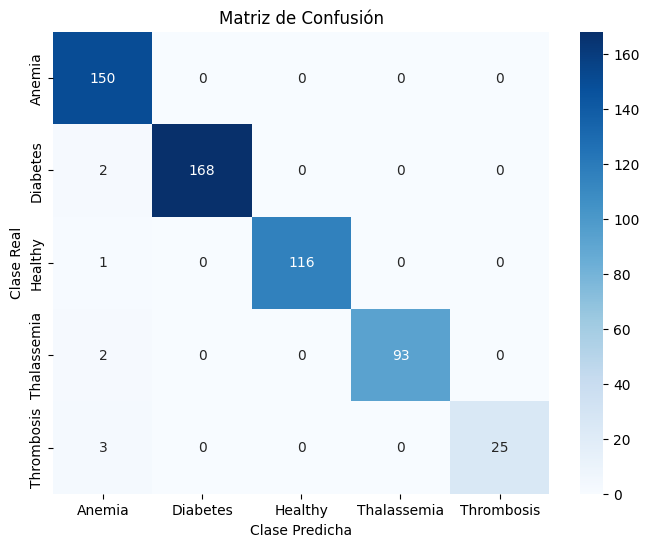

In [52]:
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_test_pred_xgb, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
class_names = encoder.categories_[0]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión')
plt.show()

Creemos un dataframe con los resultados equivocados, para entender por qué esos resultados no están correctos:

In [53]:
# Obtenemos el nombre de las clases
class_names = encoder.categories_[0]

# Convertimos los números predichos en nombres de clases
y_test_actual = np.argmax(y_test_encoded, axis=1)
y_test_actual_names = [class_names[i] for i in y_test_actual]

y_test_predicted = np.argmax(y_test_pred_xgb, axis=1)
y_test_predicted_names = [class_names[i] for i in y_test_predicted]

# Identificamos los índices de los errores
error_indices = (y_test_actual != y_test_predicted)

# Creamos un dataframe con los resultados equivocados
df_errors = pd.DataFrame({
    'Indice': X_test.index[error_indices],
    'Predicción Esperada': [class_names[i] for i in y_test_actual[error_indices]],
    'Predicción Real': [class_names[i] for i in y_test_predicted[error_indices]]
})

# Agregamos las variables predictoras para un análisis más detallado.
df_errors = pd.concat([df_errors.reset_index(drop=True), 
                       X_test[error_indices].reset_index(drop=True)], axis=1)
df_errors[['Indice','White Blood Cells', 'Red Blood Cells', 'Hematocrit', 'Predicción Esperada','Predicción Real']]

,Indice,White Blood Cells,Red Blood Cells,Hematocrit,Predicción Esperada,Predicción Real
0,2738,0.405680,0.328027,0.561552,Healthy,Anemia
1,2414,0.749872,0.375216,0.770726,Thrombosis,Anemia
2,2731,0.989058,0.483537,0.926962,Thrombosis,Anemia
3,2708,0.785230,0.768724,0.622651,Thalassemia,Anemia
4,2766,0.304409,0.466161,0.053087,Diabetes,Anemia
5,2553,0.826346,0.883065,0.256472,Thalassemia,Anemia
6,2402,0.366764,0.698967,0.029899,Diabetes,Anemia
7,2806,0.526411,0.617095,0.982223,Thrombosis,Anemia


El modelo para estos valores predice anemia, porque (excepto para los números 2708 y 2806) presentan al menos un valor relacionado con la sangre bajo en comparación con el valor esperado, como se puede observar en los boxplots realizados durante la exploración.

Casos evidentes son el 2766 y el 2402, que tienen valores de hematocritos inferiores a 0.1, pero esto se debe a la diabetes. Sin embargo, como se puede observar en el boxplot de enfermedades y hematocritos, son evidentes excepciones, ya que en todos los demás casos un valor de hematocritos inferior a 0.15 indica anemia.

### Conclusiones

El modelo XGBoost tiene un rendimiento muy bueno y muy buena generalización, a pesar de tener un ligero overfitting. Tal y como hemos observado, tiene muy pocos errores en test, que son debidos a datos extremos en los análisis de sangre, no a una mala generalización del modelo.

# Conclusiones finales

Tras haber creado nuestro modelo con las técnicas SVM, KNN Neighbours, Decission Tree y XGBoost, elegiremos como mejor modelo el de XGBoost, ya que, teniendo en cuenta que todos nuestros modelos generalizan bastante bien, es el que tiene la accuracy más alta en test, un 97%. Además, es el que tiene la accuracy media más alta en la validación cruzada (96.1%) y su desviación estándar de las diferentes accuracys de la CV (0.007) es muy baja. Por lo tanto, elegimos este modelo por ser el que mejor generaliza y el más robusto.

# Guardado del mejor modelo

In [ ]:
'''# Salvare il modello migliore
model_save_path = os.path.join(MODELS_LOCATION, "disease_classification.joblib")
dump(modelo_XGB, model_save_path)
print(f"Modelo guardado con éxito en {model_save_path}")'''

In [120]:
# Cargamos el modelo guardado
best_xgb_model = load(model_save_path)
cv_scores = cross_val_score(best_xgb_model, X_train, y_train_encoded, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.97050938 0.95710456 0.95442359]
Accuracy media de la validación cruzada: 0.961
Desviación estándar de las diferentes accuracys de la CV: 0.007


In [121]:
class_names

array(['Anemia', 'Diabetes', 'Healthy', 'Thalassemia', 'Thrombosis'],
      dtype=object)

Observamos que el modelo se ha cargado correctamente y que su rendimiento no se ha alterado.